# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '../../../../Downloads/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

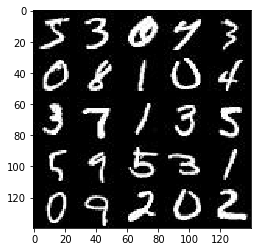

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

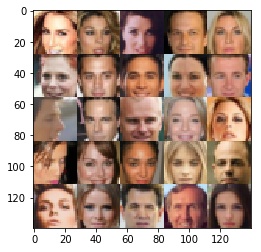

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, shape = [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 3x3x256
        
        flat = tf.reshape(x3, (-1, 3*3*256) )
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')  # valid -> size: 2 * 3 + 1
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize ( @chris_lapollo Batch Normalization lesson -> UPDATE_OPS)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # show stats every 10 batches
                if batch_i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show images every 100 batches
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
            # end of Epoch images
            print('State of the art after epoch', epoch_i+1)
            show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.9545


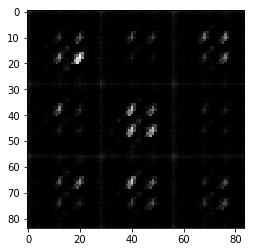

Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.1299
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 1.0275


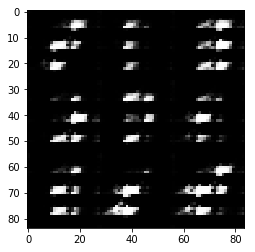

Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.3398
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.9306
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.9978
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 1.0182


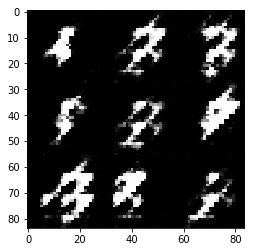

Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 1.6108
Epoch 1/2... Discriminator Loss: 1.9923... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.2160
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.0756


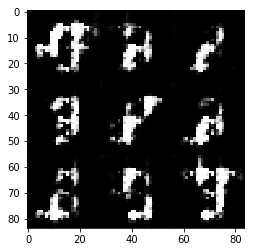

Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 1.4233
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.9558
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 1.3041
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.1757
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.4836
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.1183


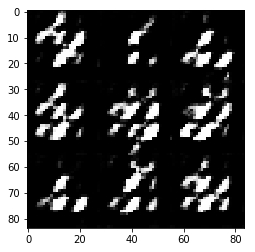

Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.3230
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.9592
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 1.0334
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.7380


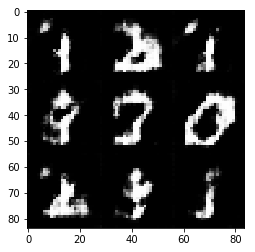

Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.2469
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.1300


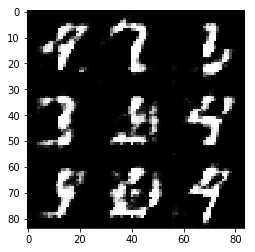

Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.1579
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.2569
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.9362
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 1.0029


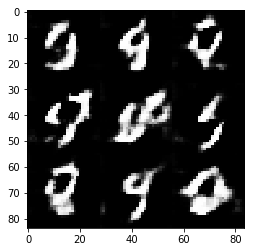

Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.1133
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.9521


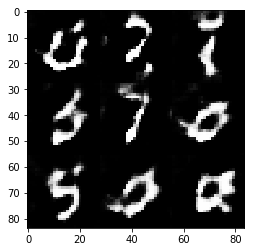

Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.9835
State of the art after epoch 1


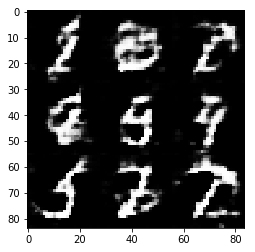

Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.8032


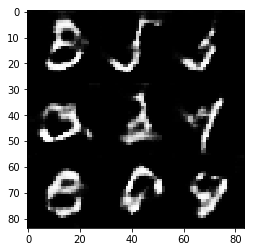

Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.8240


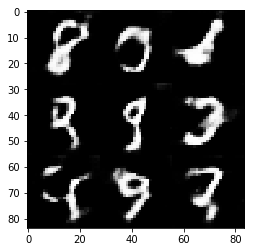

Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.9869
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.9326
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.8503


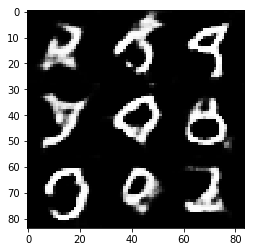

Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 1.0284
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 0.9694


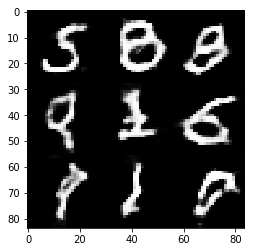

Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.8951


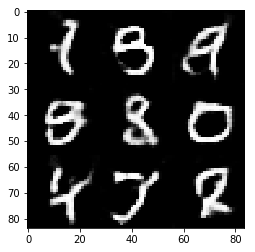

Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.9662
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.9465


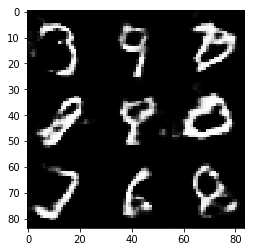

Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.9189


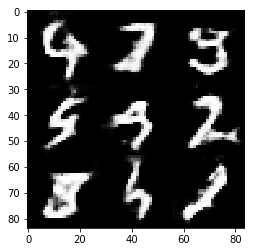

Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.9335


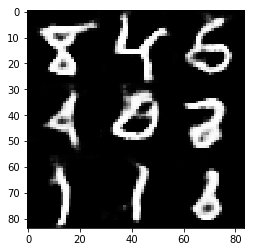

Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 1.0577
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.4536... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.7992


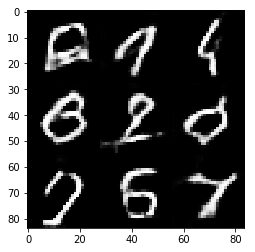

Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.8997
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7390
State of the art after epoch 2


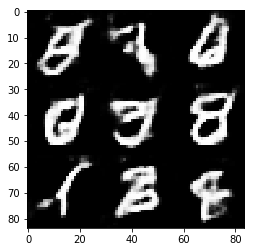

In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.8584... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7955


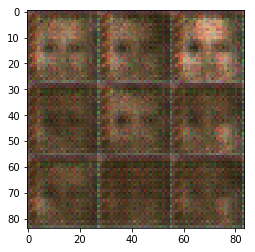

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.7637


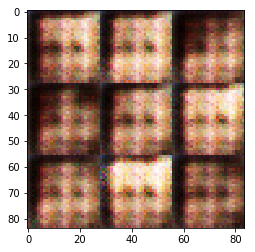

Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7522


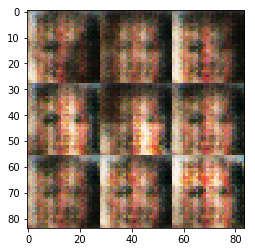

Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9555


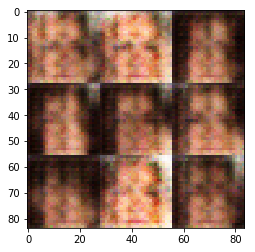

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8018


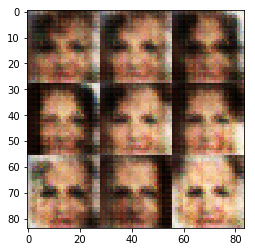

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8495


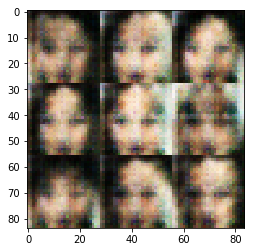

Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7735


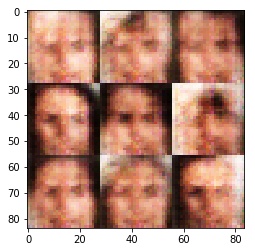

Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0345


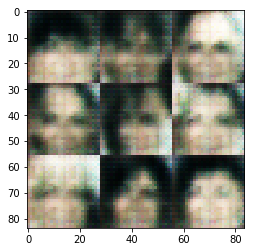

Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 2.0688
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.2223


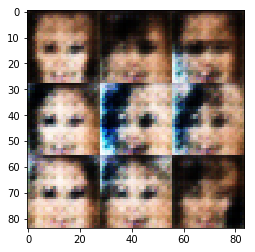

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.8046
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8709


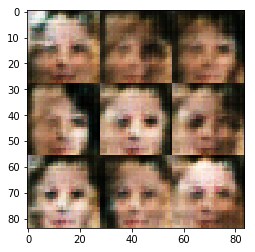

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.9068


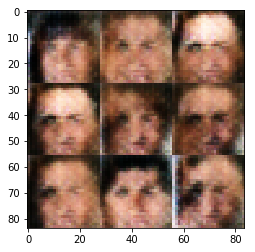

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9380


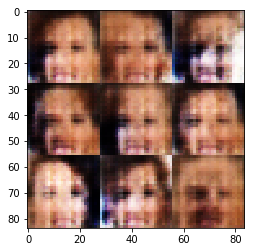

Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8518


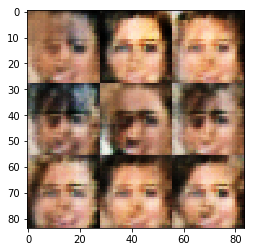

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9176


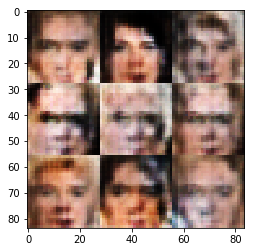

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8141


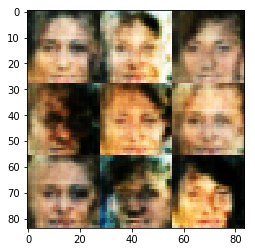

Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8572


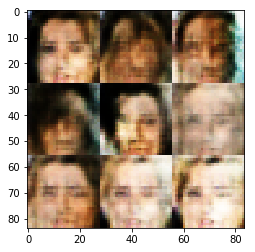

Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8861


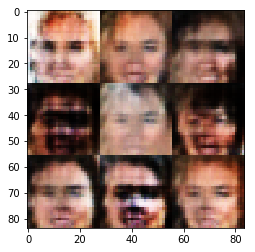

Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8209


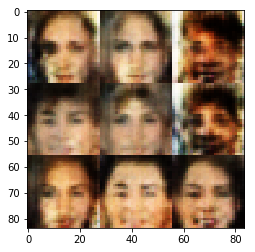

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8870


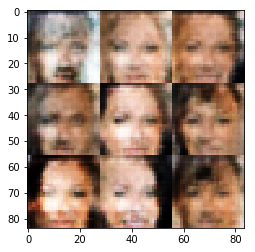

Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.9054


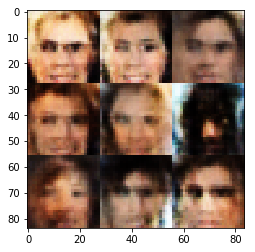

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7700


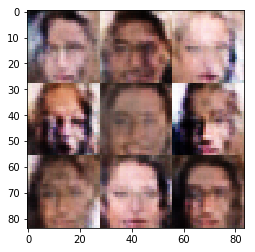

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.9678


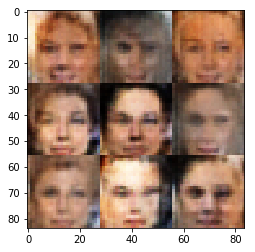

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7805


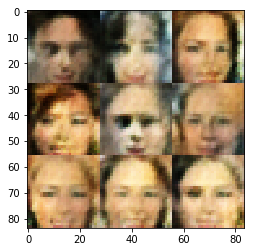

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.9393


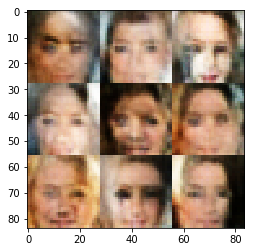

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8946


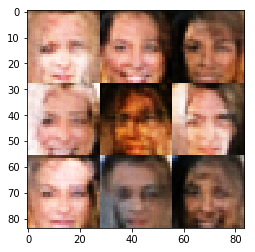

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8853


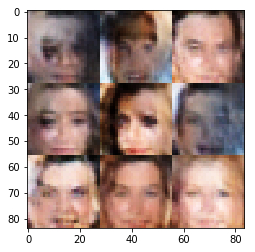

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8603


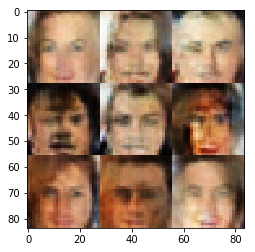

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8573


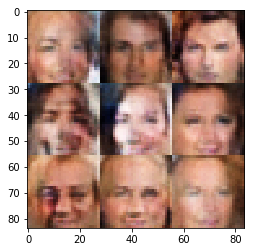

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8103


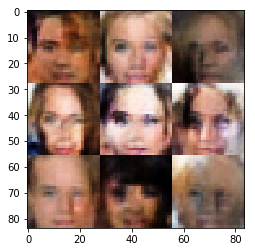

Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 1.6022
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.9077


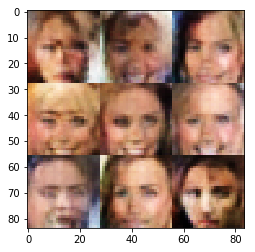

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8649


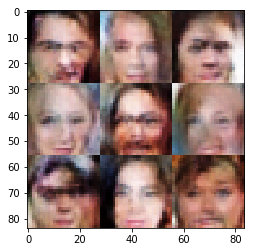

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8177
State of the art after epoch 1


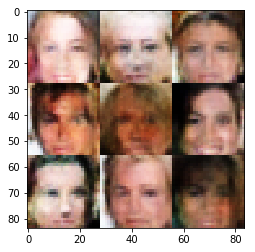

In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.